In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
from scipy.special import softmax
from collections.abc import Sequence
from matplotlib.colors import LinearSegmentedColormap

from PPTM.embedded_score import UMAP_Fast, Embedded_SCORE_C
from PPTM.utils import *
import spacy
import pickle
from tqdm import tqdm
import textwrap


# python -m spacy download en_core_web_sm

# Load spaCy's small English model
nlp = spacy.load('en_core_web_sm')

/Users/yguo23/Desktop/Projects/newContextualizedTopicScore/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Load SA dataset**

In [2]:
with np.load(
  "./npz/0331130023/SA_bert_c_10_metadata_updated.npz", "rb", allow_pickle=True
) as data:
  dic = data["dic"]
  # word_freq = data["word_freq"]
  word_count = data["word_count"]
  min_word_count = data["min_word_count"]
  doc_indices = data["doc_indices"]
  num_doc = data["num_doc"]
  num_word = data["num_word"]
  dim = data["dim"]
  doc_lens = data['doc_lens']
word_arr = np.load("./npz/0331130023/SA_word_arr_lemma.npy")
word_stem = np.load("./npz/0331130023/SA_word_stem_lemma.npy")
paper = pd.read_csv('dataset/SA/paper.csv')
title = paper['title']
abstract = paper['abstract']

/var/folders/sf/y630z01d2tq18cmf1h2k_qxr0000gn/T/ipykernel_11747/993155065.py:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  paper = pd.read_csv('dataset/SA/paper.csv')


### **Fit umap model**

PPTM fits a umap model to reduce 762 dimensional BERT-pretrained embedding to a 10 dimensional space using 10\% data. This takes roughly 90 mins on PC.

In [3]:
# NOTE: Uncomment the following code if you want to fit a umap model yourself. This takes roughly 90 mins.
# seed = 2024
# fit_prop = 0.1
# umap_get = UMAP_Fast(
#   new_dim=10,
#   n_neighbors=100,
#   min_dist=0.1,
#   fit_prop=fit_prop,
#   npy_path="npz/0331130023/SA_bert_c_10_combined_repr.npy",
#   tick="SA",
#   random_seed=seed,
#   pca_save_dir="./pkl/0331130023",
#   pca_data_save_dir="./npz/0331130023",
# )
# umap_get.transform_all_points(
#   load_dir='./pkl/0331130023',
#   dump_dir='./pkl/0331130023',
#   save_dir='./npz/0331130023', 
#   batch_size=30000
# )
# del umap_get

# # Save umap model
# with open(f"./pkl/0331130023/SA_word_umap_10_nn_100_mdist_0.1_sample_0.1_seed_2024.pkl", "wb") as file:
#   pickle.dump(umap_get.umap_model,file)


### **Run PPTM**

Uncomment the following code if you want to fit yourself. The fitting will take few hours on PC.

In [4]:
# NOTE: Uncomment the following code if you want to fit a umap model yourself. This takes roughly 90 mins.
# seed = 2024
# num_topic = 13
# num_hyperword = 2400
# init_num = 100
# es_model = Embedded_SCORE_C(
#   num_doc=num_doc,
#   doc_lens=doc_lens,
#   num_topic=num_topic,
#   num_hyperword=num_hyperword,
#   npy_path="npz/0331130023/SA_word_umap_10_nn_100_mdist_0.1_sample_0.1_seed_2024.npy",
#   dim_repr=10,
#   tick="SA",
#   random_seed=seed,
#   clustering_method="mini-batch kmeans",
#   vertex_hunting_method="SPA",
#   remove_outlier=True,
#   cluster_first=False,
#   contamination=0.2,
#   n_neighbors=10,
#   num_init = init_num,
#   quantile=0.95,
#   percentage=0.05,
#   calculate_W_hat=True,
#   num_batches_cal_W_hat = 20,
#   num_batches_cal_density = 20,
# )
# es_model.fit_all()

# # Save es_model.
# with open(f"./pkl/0331130023/SA_umap_10_nn_100_mdist_0.1_sample_0.1_nhyper_2400_seed_2024.pkl", "wb") as file:
#     pickle.dump(es_model,file)

# Load es_model
with open(f"./pkl/0331130023/SA_umap_10_nn_100_mdist_0.1_sample_0.1_nhyper_2400_seed_2024.pkl", "rb") as file:
    es_model = pickle.load(file)

### **Top words and documents**

In [5]:
# NOTE: Get top words for each topic.

min_occ = 5
lst_elem, lst_indices = es_model.get_top_k_words(min_occ, k=50, word_arr=word_arr)
for topic in range(es_model.num_topic):
  print(f"Topic {topic+1}: {lst_elem[topic]}")

Topic 1: ['cure', 'cured', 'survival', 'fitness', 'surviving', 'survivor', 'immunity', 'reproduction', 'dispersal', 'nest', 'lead', 'coping', 'hazards', 'damages', 'recovery', 'damage', 'hazard', 'stress', 'frailty', 'frailties', 'conservation', 'proportional', 'proportionality', 'risks', 'survivors', 'shock', 'failure', 'acquired', 'vital', 'reproductive', 'nesting', 'admissions', 'defect', 'productivity', 'failures', 'hazardous', 'censored', 'censoring', 'condition', 'defects', 'violations', 'deficiency', 'conditions', 'cause', 'causes', 'censor', 'censors', 'cox', 'shocks', 'scale']
Topic 2: ['posterior', 'posteriors', 'hypergeometric', 'hyperparameters', 'hyperparameter', 'bayesian', 'bayes', 'priors', 'prior', 'brownian', 'bayesians', "bayes'", 'reference', 'dirichlet', 'default', 'subjective', 'integrated', 'objective', 'gibbs', 'sampler', 'samplers', 'interactive', 'representative', 'systematic', 'mcmc', 'msc', 'svm', 'cdf', 'standardized', 'frequentist', 'frequent', 'frequentis

In [6]:
# NOTE: Get top docs for each topic.

anchor_doc_info = es_model.get_top_k_docs(k=5, doc_indices=doc_indices)
for topic in range(es_model.num_topic):
    print(f"Topic {topic+1}: {title[anchor_doc_info[topic]]}\n")


Topic 1: 27918                    A Model For Informative Censoring
39547    Alternative Approaches To Study Lifetime Data ...
50097    Estimating The Loss In Expectation Of Life Due...
48641    The Accelerated Failure Time Model - A Useful ...
48994    Relative Survival And The Estimation Of Net Su...
Name: title, dtype: object

Topic 2: 37735    Bayesian Analysis Of Birnbaum-saunders Distrib...
39119    Finite Mixture Of Gamma Distributions: A Conju...
83063        Hellinger Distance And Non-informative Priors
27380        Noninformative Priors And Nuisance Parameters
39090    Bayesian R-estimates In Two-sample Location Mo...
Name: title, dtype: object

Topic 3: 50732    Up-front Versus Sequential Randomizations For ...
48593    Data Monitoring Boards In The Pharmaceutical-i...
49183    Comparing The Effects Of Different Durations O...
50796    Estimation Of Treatment Effect For The Sequent...
46864    A Three-stage Clinical Trial Design For Rare D...
Name: title, dtype: object

Topi

### **Contour plots**

In [7]:
# Titles
titles = ["Survival Analysis","Bayesian Satistics","Clinical Trial","Computational Statistics","Stochastic Processes and Time Series","Experimental Design","Hypothesis Testing","Variable Selection","Probability Theory","Social and Economic Studies","Nonparametric Statistics","Uncertainty Quantification","Regression Analysis",]
titles_ac = ["SA","BS","CT","CS","SPTS","ED","HT","VS","PT","SES","NS","UQ","RA",]
region_coords_list1 = [[[-1.0,8.3]],[[-2.0,16.7]],[[-1.5,-0.2]],[[5.7,14.0]],[[4.6,11.3]],[[4.6,5.7]],[[-4.7,6.8]],[[-8.3,-1.3]],[[-1.8,-1.7]],[[-2.3,8.5]],[],[[10.5,13.6]],[],]
region_coords_list1 = [np.array(elem) for elem in region_coords_list1]
region_coords_list2 = [['1'],['2'],['3'],['4'],['5'],['6'],['7'],['8'],['9'],['10'],[],['11'],[],]
region_coords_list2 = [np.array(elem) for elem in region_coords_list2]

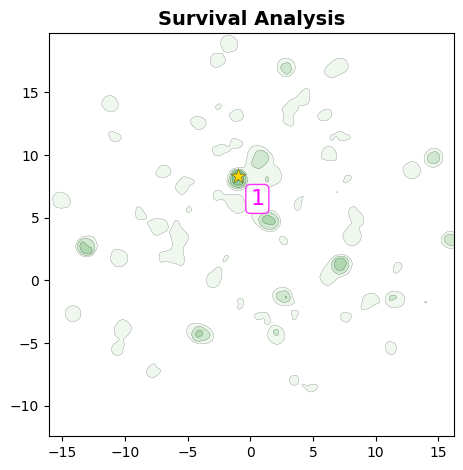

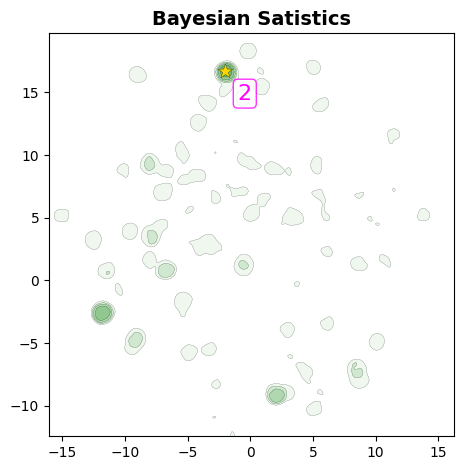

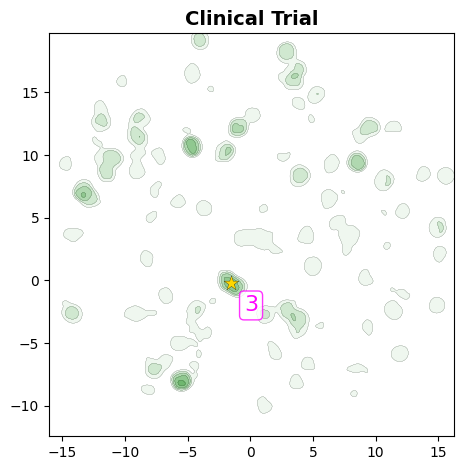

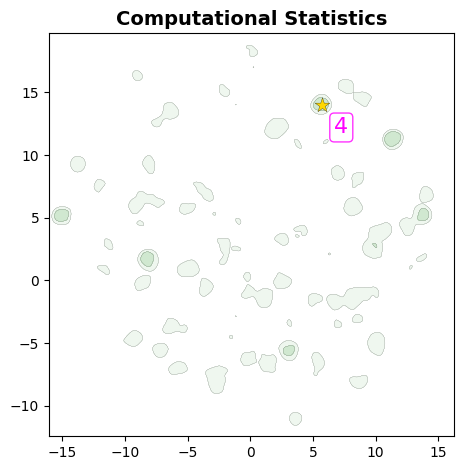

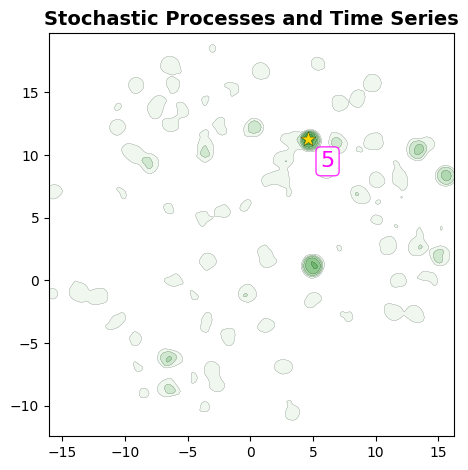

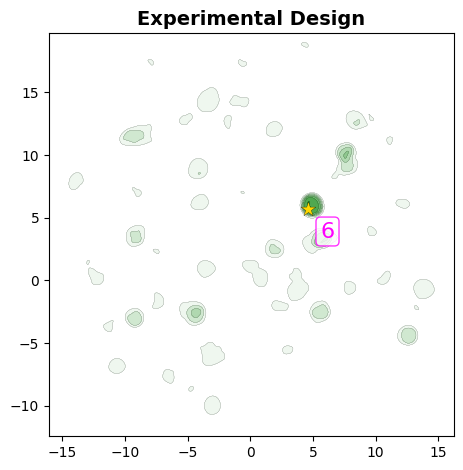

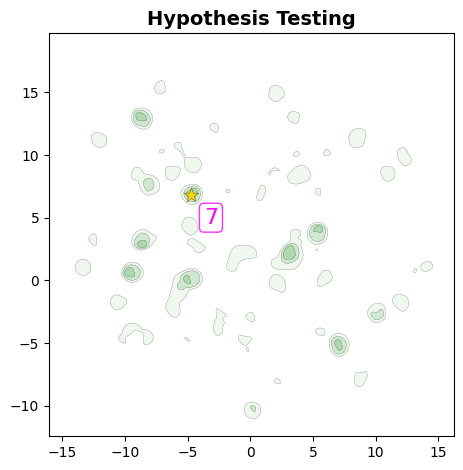

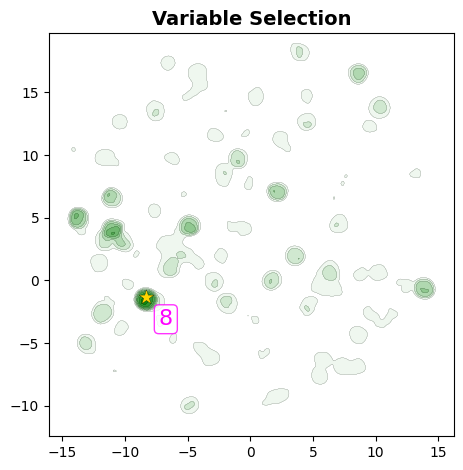

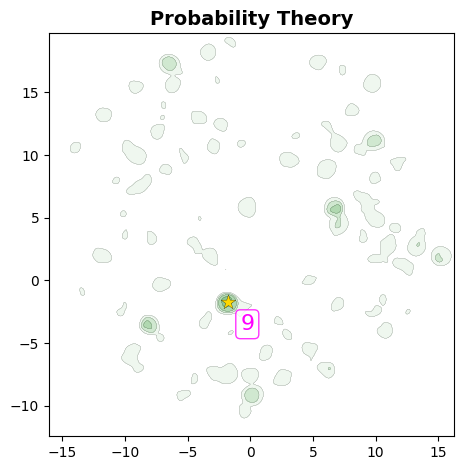

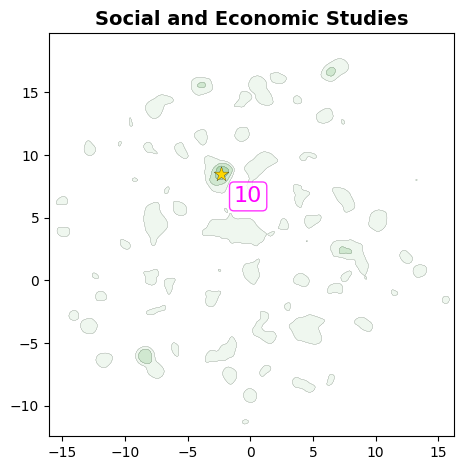

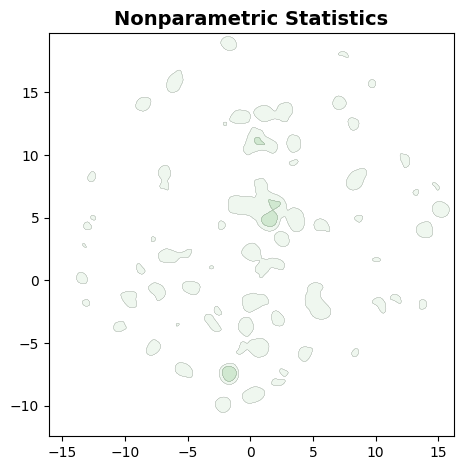

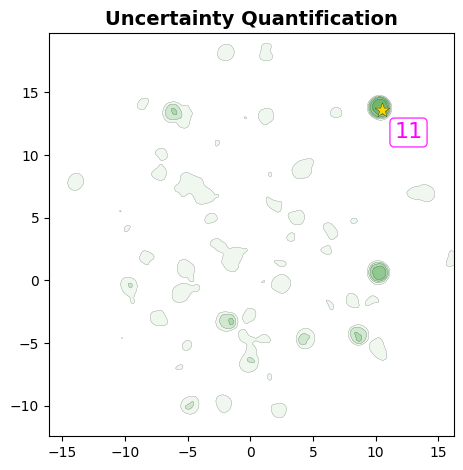

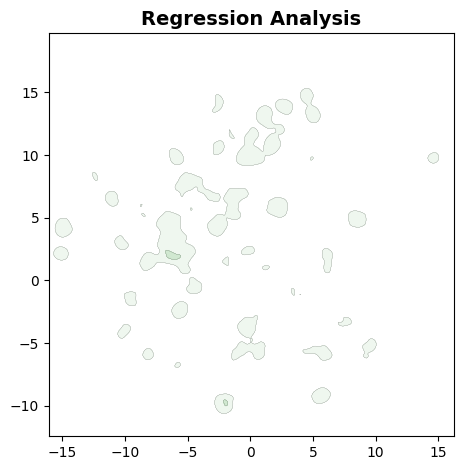

In [8]:
# es_model.plot_density_regions(
# 	seed=2024,
# 	# save_path="./npz/0331130023/SA_contour_plot_variables_umap_10_nn_100_mdist_0.1_sample_0.1_seed_2024.npz",
#   load_path_umap2="./pkl/0331130023/SA_umap_2_nn_10_mdist_0.1_sample_0.1_seed_4048.pkl",
# 	region_coords_list1=region_coords_list1,
#  	region_coords_list2=region_coords_list2,
#   titles=titles,
#   titles_ac=titles_ac,
# )
es_model.plot_density_regions(
	seed=2024,
	load_path="./npz/0331130023/SA_contour_plot_variables_umap_10_nn_100_mdist_0.1_sample_0.1_seed_2024.npz",
	region_coords_list1=region_coords_list1,
 	region_coords_list2=region_coords_list2,
  titles=titles,
  titles_ac=titles_ac,
  save_plot_dir="./fig/0331130023",
  save_plot_tick="SA",
)

In [10]:
# region 1
topic = 0
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-1.0,8.3]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.5)
)[0]
print(f"Region 1 (Survival Analysis): {list(set(word_arr[inds].tolist()))}")
# region 2
topic = 1
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-2.0,16.7]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.3)
)[0]
print(f"Region 2 (Bayesian Statistics): {list(set(word_arr[inds].tolist()))}")
# region 3
topic = 2
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-1.5,-0.2]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.5)
)[0]
print(f"Region 3 (Clinical Trail): {list(set(word_arr[inds].tolist()))}")
# region 4
topic = 3
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([5.7,14.0]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.25)
)[0]
print(f"Region 4 (Computational Statistics): {list(set(word_arr[inds].tolist()))}")
# region 5
topic = 4
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([4.6,11.3]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.65)
)[0]
print(f"Region 5 (Stochestic Process & Time Series): {list(set(word_arr[inds].tolist()))}")
# region 6
topic = 5
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([4.6,5.7]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.7)
)[0]
print(f"Region 6 (Experimental Design): {list(set(word_arr[inds].tolist()))}")
# region 7
topic = 6
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-4.7,6.8]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.3)
)[0]
print(f"Region 7 (Hypothesis Testing): {list(set(word_arr[inds].tolist()))}")
# region 8
topic = 7
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-8.3,-1.3]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.6)
)[0]
print(f"Region 8 (Variable/Model Selection): {list(set(word_arr[inds].tolist()))}")
# region 9
topic = 8
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-1.8,-1.7]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.42)
)[0]
print(f"Region 9 (Probability Theory): {list(set(word_arr[inds].tolist()))}")
# region 10
topic = 9
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([-2.3,8.5]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.35)
)[0]
print(f"Region 10 (Social & Economic Studies): {list(set(word_arr[inds].tolist()))}")
# region 11
topic = 11
inds = np.where(
    (np.linalg.norm(es_model.new_word_repr[:, :2] - np.array([10.5,13.6]), axis=1) <= 0.5) &
    (es_model.w_word[:, topic] >= 0.2)
)[0]
print(f"Region 11 (Uncertainty Quantification): {list(set(word_arr[inds].tolist()))}")

Region 1 (Survival Analysis): ['evolutionary', 'compatibility', 'century', 'healthy', 'fitness', 'reproducers', 'diagnostics', 'survival', 'survivals', 'hormone', 'nest', 'latent', 'developmental', 'variable', 'recovery', 'conservation', 'connective', 'parent', 'brain', 'behavioral', 'fertility', 'breast', 'process', 'development', 'nesting', 'related', 'differentiable', 'draw', 'dies', 'living', 'frailties', 'mass', 'individual', 'instability']
Region 2 (Bayesian Statistics): ['characterisation', 'connect', 'classifies', 'characterizes', 'characterise', "variables'", 'posteriors', 'illustrated', 'characterises', 'illustrate', 'variables', 'distribution', 'justifies', 'characterising', 'conceptualize', 'characterizing', 'characterisations', 'describing', 'posterior', 'character', 'characterize']
Region 3 (Clinical Trail): ['treatment', 'therapy', 'prevention', 'cures', 'rank', 'clinic', 'topical', 'systematic', 'program', 'base', 'treating', 'treated', 'responsible', 'medication', 'pro

### **Word heptagon for different <code>bandwidth</code>**

bandwidth is 0.02


Calculating word densities.: 100%|██████████| 20/20 [03:10<00:00,  9.54s/it]


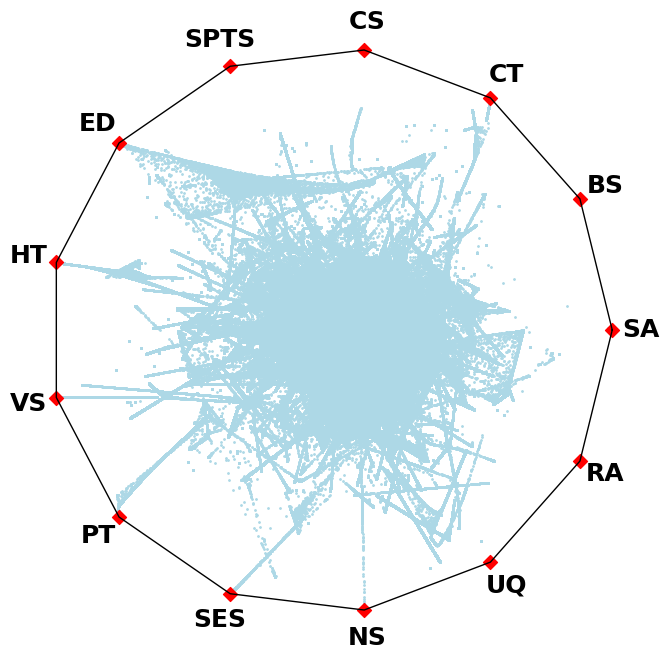

bandwidth is 0.1


Calculating word densities.: 100%|██████████| 20/20 [04:41<00:00, 14.07s/it]


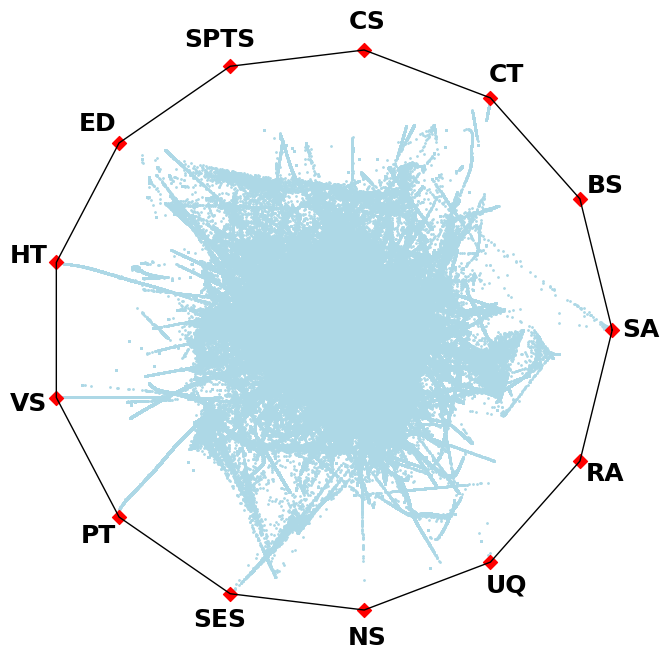

bandwidth is 0.2


Calculating word densities.: 100%|██████████| 20/20 [06:27<00:00, 19.40s/it]


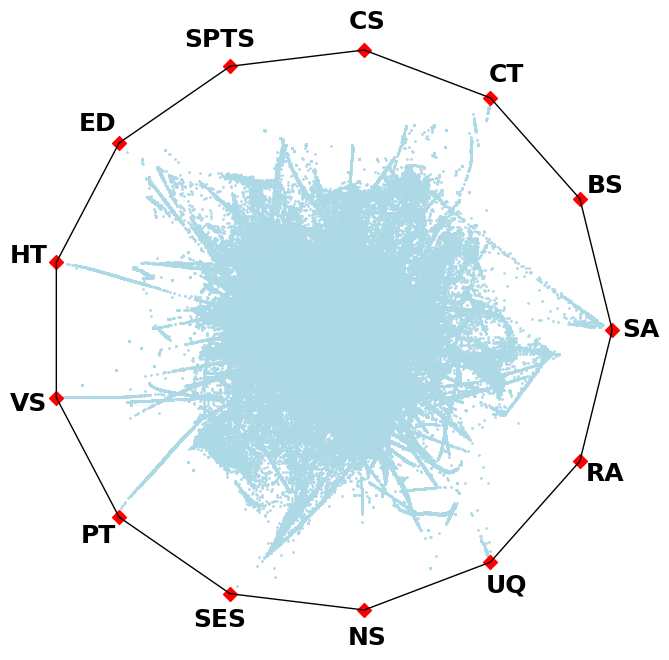

bandwidth is 0.5


Calculating word densities.: 100%|██████████| 20/20 [05:49<00:00, 17.49s/it]


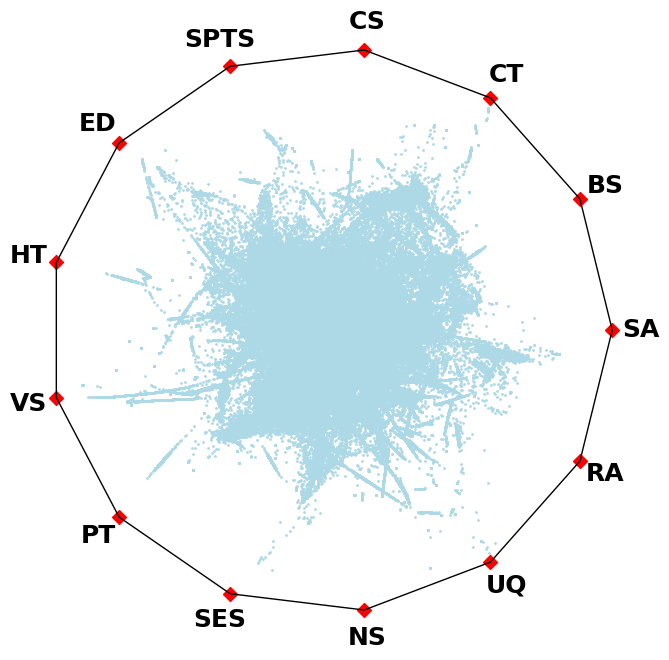

In [11]:
# NOTE: 2. Plot word heptagon with different badnwidth.
for bandwidth in [0.02, 0.1, 0.2, 0.5]:
  es_model.get_word_density(bandwidth=bandwidth, down_sample=None, minibatch=True);
  vectors = es_model.word_mixed_member 
  angles = np.linspace(0, 2 * np.pi, es_model.num_topic, endpoint=False)
  polygon_vertices = np.array([np.cos(angles), np.sin(angles)]).T
  mapped_points = vectors @ polygon_vertices

  plt.figure(figsize=(8, 8))  
  plt.plot(*np.append(polygon_vertices, [polygon_vertices[0]], axis=0).T, 'k-', lw=1)  # Draw the polygon
  plt.scatter(mapped_points[:, 0], mapped_points[:, 1], color='lightblue', marker='o', s=1.0, label="Mapped points", rasterized=True)
  for i, (x, y) in enumerate(polygon_vertices):
      plt.text(x * 1.1, y * 1.1, titles_ac[i], ha='center', va='center', fontsize=18, color='black', fontweight='bold')
      plt.scatter(x, y, color='red', s=50, marker='D')

  plt.gca().set_aspect('equal', adjustable='box')
  plt.axis('off')
  plt.savefig(f"./fig/0331130023/SA_bandwidth_{bandwidth}.pdf",format="pdf",bbox_inches="tight",dpi=600)
  plt.show()


### **Polysemy word examples**

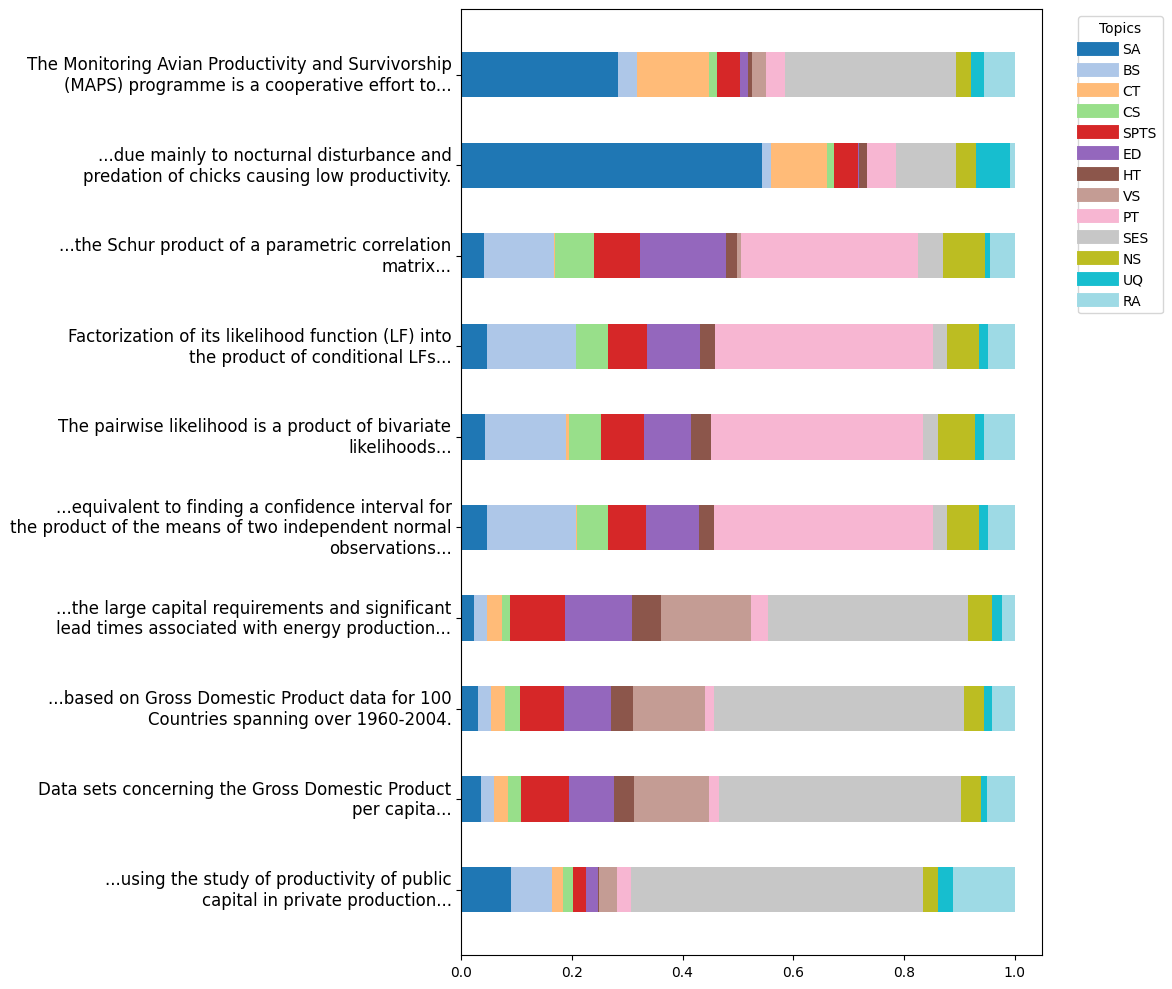

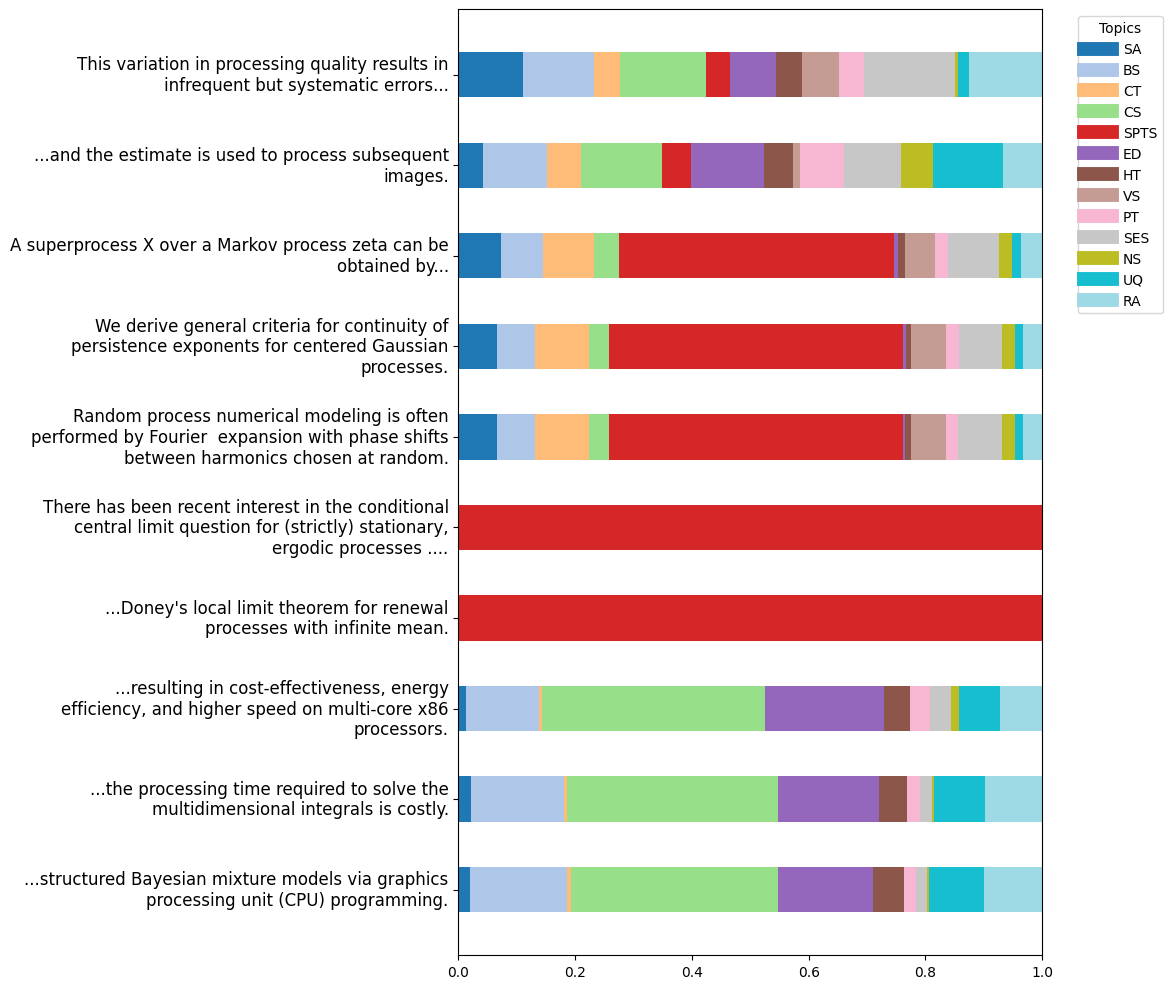

In [12]:
# NOTE: 3.viz polysemy words
# NOTE: 3.1. product
data = es_model.word_mixed_member[[1917356, 1435564, 2688344, 2335625, 1196356, 1225565, 607330, 1427495, 1747985, 1767062],:]
cases = [
  r'...using the study of productivity of public capital in private production...',
  r'Data sets concerning the Gross Domestic Product per capita...',
  r'...based on Gross Domestic Product data for 100 Countries spanning over 1960-2004.',
  r'...the large capital requirements and significant lead times associated with energy production...',
  r'...equivalent to finding a confidence interval for the product of the means of two independent normal observations...',
  r'The pairwise likelihood is a product of bivariate likelihoods...',
  r'Factorization of its likelihood function (LF) into the product of conditional LFs...',
  r'...the Schur product of a parametric correlation matrix...',
  r'...due mainly to nocturnal disturbance and predation of chicks causing low productivity.',
  r'The Monitoring Avian Productivity and Survivorship (MAPS) programme is a cooperative effort to...',
]
cases = [textwrap.fill(case, width=50) for case in cases]
topics = titles_ac

# Predefine colors for all 13 topics
colors = plt.cm.tab20(np.linspace(0, 1, 13))

# Get the top 2 topics for each case
top_topics = []
top_weights = []

for case in data:
    indices = np.argsort(case)[-2:][::-1]  # Indices of the top 2 weights (sorted in descending order)
    top_topics.append(indices)
    top_weights.append(case[indices])

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(12, 10))
bar_width = 0.35
indices = np.arange(len(cases))
bar_height = 0.5
indices = np.arange(len(cases))
for topic_idx in range(data.shape[1]):  # Iterate over all topics
    weights = data[:, topic_idx]  # Extract the weights for the current topic
    if topic_idx == 0:
        left_weights = np.zeros(len(cases))  # Start with no left layer
    ax.barh(
        indices,
        weights,
        height=bar_height,
        color=colors[topic_idx],
        label=topics[topic_idx],
        left=left_weights
    )
    left_weights += weights  # Update the left layer for the next topic
        
legend_handles = [
    plt.Line2D([0], [0], color=colors[i], lw=10, label=topics[i]) for i in range(13)
]
    
# Add labels, legend, and title
ax.set_yticks(indices + bar_width / 2)
ax.set_yticklabels(cases)
# Add the legend to the plot
ax.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    title='Topics'
)
# Adjust the y-ticks to align labels with the bar centers
ax.set_yticks(indices)
ax.set_yticklabels(cases, va='center', fontsize=12)  # 'va' aligns the text vertically

plt.tight_layout()
plt.savefig("./fig/0331130023/SA_product.pdf", format="pdf")
plt.show()


# NOTE: 3.2. process
data = es_model.word_mixed_member[[3061921, 1342906, 1302820, 1628966, 816610, 1546282, 871418, 1610649, 37323, 43193],:]
cases = [
  '...structured Bayesian mixture models via graphics processing unit (CPU) programming.', 
  '...the processing time required to solve the   multidimensional integrals is costly.', 
  '...resulting in cost-effectiveness, energy efficiency, and higher speed on multi-core x86 processors.',
  '...Doney\'s local limit theorem for renewal processes with infinite mean.', 
  'There has been recent interest in the conditional central limit question for (strictly) stationary, ergodic processes ....', 
  'Random process numerical modeling is often performed by Fourier  expansion with phase shifts between harmonics chosen at random.',
  'We derive general criteria for continuity of persistence exponents for centered Gaussian processes.',
  'A superprocess X over a Markov process zeta can be obtained by...',
  '...and the estimate is used to process subsequent images.',
  'This variation in processing quality results in infrequent but systematic errors...']
cases = [textwrap.fill(case, width=50) for case in cases]
topics = titles_ac

# Predefine colors for all 13 topics
colors = plt.cm.tab20(np.linspace(0, 1, 13))

# Get the top 2 topics for each case
top_topics = []
top_weights = []

for case in data:
    indices = np.argsort(case)[-2:][::-1]  # Indices of the top 2 weights (sorted in descending order)
    top_topics.append(indices)
    top_weights.append(case[indices])

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(12, 10))
bar_width = 0.35
indices = np.arange(len(cases))

# # Loop through cases to plot only the top 2 topics
# for i, (topic_indices, weights) in enumerate(zip(top_topics, top_weights)):
#     for j, (topic_idx, weight) in enumerate(zip(topic_indices, weights)):
#         ax.barh(
#             indices[i] + j * bar_width,  # Offset the bar positions for two topics
#             weight,
#             height=bar_width,
#             color=colors[topic_idx],  # Consistent color based on the topic
#             #label=f'{topics[topic_idx]}' if (i == 0 and topics[topic_idx] not in ax.get_legend_handles_labels()[1]) else ""
#         )

# Loop through topics and stack them horizontally
bar_height = 0.5
indices = np.arange(len(cases))
for topic_idx in range(data.shape[1]):  # Iterate over all topics
    weights = data[:, topic_idx]  # Extract the weights for the current topic
    if topic_idx == 0:
        left_weights = np.zeros(len(cases))  # Start with no left layer
    ax.barh(
        indices,
        weights,
        height=bar_height,
        color=colors[topic_idx],
        label=topics[topic_idx],
        left=left_weights
    )
    left_weights += weights  # Update the left layer for the next topic
    
legend_handles = [
    plt.Line2D([0], [0], color=colors[i], lw=10, label=topics[i]) for i in range(13)
]
# Add labels, legend, and title
ax.set_yticks(indices + bar_width / 2)
ax.set_yticklabels(cases)
# Add the legend to the plot
ax.legend(
    handles=legend_handles,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    title='Topics'
)
# Adjust the y-ticks to align labels with the bar centers
ax.set_yticks(indices)
ax.set_yticklabels(cases, va='center', fontsize=12)  # 'va' aligns the text vertically

plt.tight_layout()
plt.savefig("./fig/0331130023/SA_process.pdf", format="pdf")
plt.show()


### **Plot topic trend**

start calculating W_hat using ridge method


100%|██████████| 20/20 [00:02<00:00,  9.94it/s]
/Users/yguo23/Desktop/Projects/newContextualizedTopicScore/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yguo23/Desktop/Projects/newContextualizedTopicScore/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


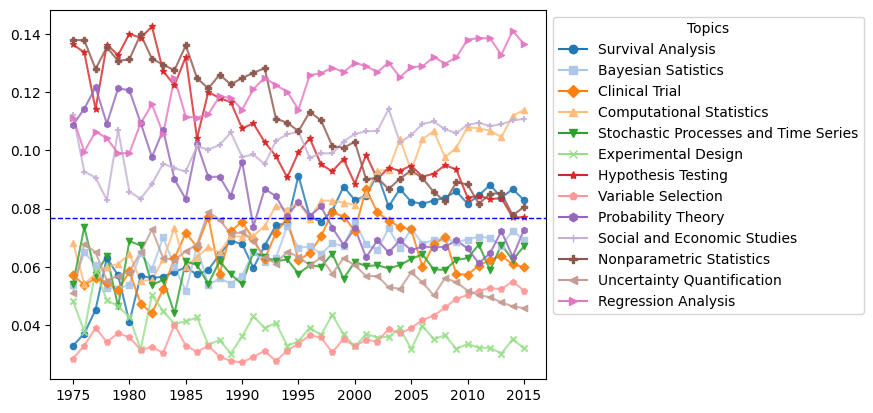

In [13]:
# NOTE: 4. Plot topic trend.
lambda_reg = 0.002
es_model.model.get_W_hat(regression_type="ridge",lambda_reg=lambda_reg)
# TODO: topic trends
paper_year = paper['year'].to_numpy()[doc_indices]
year_start = 1975
year_end = 2020
trends = np.zeros((es_model.num_topic,year_end-year_start+1))
# topic_assign = np.argmax(es_model.model.W_hat,axis=0)
for year in range(year_start, year_end+1):
  idx = np.where(paper_year==year)[0]
  W_hat_year = es_model.model.W_hat[:,idx]
  trends[:,year-year_start] = np.mean(W_hat_year,axis=1)

# Define markers and colors
markers = ['o', 's', 'D', '^', 'v', 'x', '*', 'p', 'h', '+', 'P', '<', '>', 'X', '|']
colors = plt.cm.tab20.colors  # Use a colormap with enough distinct colors

# Plot each topic with a unique marker and color
for j in range(es_model.num_topic):
    plt.plot(
        range(year_start, year_end + 1),
        trends[j],
        linestyle='-', 
        color=colors[j % len(colors)], 
        alpha=0.8,
        zorder=1
    )  # Line plot
    plt.scatter(
        range(year_start, year_end + 1), 
        trends[j], 
        marker=markers[j % len(markers)], 
        color=colors[j % len(colors)],
        alpha=0.9,
        zorder=2,
        s=20,
    )  # Scatter plot
    
legend_handles = []
for j in range(es_model.num_topic):
    legend_handles.append(
        Line2D(
            range(year_start, year_end + 1),
            trends[j],
            color=colors[j % len(colors)],
            marker=markers[j % len(markers)],
            label=titles[j],
            linestyle='-',
            markersize=6,
            linewidth=1.5
        )
    )
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1), title='Topics', markerscale=1)    
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Topics', markerscale=1)
# plt.ylim(-0.01,0.21)
plt.axhline(y=1/13,color='blue',linestyle='--',linewidth=1)
plt.savefig(f"./fig/0331130023/SA_topic_trend_ridge_{lambda_reg}.pdf", format="pdf", bbox_inches="tight")
plt.show()